<a href="https://colab.research.google.com/github/RamaSiritha/RamaSiritha_INFO5731_Spring2021/blob/main/In_class_exercise_07.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **The seventh in-class-exercise (20 points in total, 3/16/2021)**

Question description: In the last in-class-exercise (exercise-06), you collected the titles of 100 articles about data science, natural language processing, and machine learning. The 100 article titles will be used as the text corpus of this exercise. Perform the following tasks:

In [1]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [2]:
import os
def install_java():
  !apt-get install -y openjdk-8-jdk-headless -qq > /dev/null
  os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
  !java -version
install_java()

openjdk version "11.0.10" 2021-01-19
OpenJDK Runtime Environment (build 11.0.10+9-Ubuntu-0ubuntu1.18.04)
OpenJDK 64-Bit Server VM (build 11.0.10+9-Ubuntu-0ubuntu1.18.04, mixed mode, sharing)


In [3]:
!pip install --upgrade gensim

     |████████████████████████████████| 24.2MB 1.3MB/s 
  Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0


In [4]:
import spacy.cli
spacy.cli.download("en")

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/usr/local/lib/python3.7/dist-packages/en_core_web_sm -->
/usr/local/lib/python3.7/dist-packages/spacy/data/en
You can now load the model via spacy.load('en')


## (1) (8 points) Generate K topics by using LDA, the number of topics K should be decided by the coherence score, then summarize what are the topics. You may refer the code here: 

https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/

In [6]:
pip install pyLDAvis

     |████████████████████████████████| 1.7MB 8.7MB/s 
  Created wheel for pyLDAvis: filename=pyLDAvis-3.2.2-py2.py3-none-any.whl size=135593 sha256=bc329e4b66e6ab9f4feeef30442d020778bae35beb241b0f24b25bfc9d5a90a6
  Stored in directory: /root/.cache/pip/wheels/74/df/b6/97234c8446a43be05c9a8687ee0db1f1b5ade5f27729187eae
Successfully built pyLDAvis


In [7]:
# Write your code here

import re
import numpy as np
import pandas as pd
from pprint import pprint
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import spacy
import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable
/usr/local/lib/python3.7/dist-packages/past/builtins/misc.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Mapping


In [8]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

In [10]:
google_articles_titles = pd.read_csv('https://raw.githubusercontent.com/RamaSiritha/RamaSiritha_INFO5731_Spring2021/main/gschlr.csv', encoding = "ISO-8859-1")
google_articles_titles.head(10)

,ï»¿Machine learning,"Each time each type of sort button is clicked, changes from Ascending to Descending",Unnamed: 2,your search,Button to Reset to original ordering,Order by your notes,"Authors, year, editor",Button - use to order by YEAR,First author,Title,text,Link 1,Link 2,Unnamed: 13,"dois, after using crossref button"
0,Natural language processing,PDF and IExplorer Issues:,NaN,Machine learning,1,NaN,TM Mitchell - 1997 - carabinier.gov.md,1997,Mitchell,Machine learning,This exciting addition to the McGraw-Hill Seri...,NaN,https://carabinier.gov.md/sites/default/files/...,NaN,NaN
1,NaN,https://www.itsupportguides.com/windows-7/adob...,NaN,Machine learning,2,NaN,"I Goodfellow, Y Bengio, A Courville - Deep lea...",2016,"Goodfellow,",Machine learning basics,Page 1. Machine Learning Basics Lecture slides...,NaN,https://www.deeplearningbook.org/slides/05_ml.pdf,NaN,NaN
2,NaN,https://helpx.adobe.com/acrobat/kb/epm-support...,NaN,Machine learning,3,NaN,"JW Shavlik, T Dietterich, TG Dietterich - 1990...",1990,"Shavlik,",Readings in machine learning,The ability to learn is a fundamental characte...,NaN,https://books.google.com/books?hl=en&lr=&id=Ug...,NaN,NaN
3,NaN,NaN,NaN,Machine learning,4,NaN,"MI Jordan, TM Mitchell - Science, 2015 - scien...",2015,"Jordan,","Machine learning: Trends, perspectives, and pr...",Machine learning addresses the question of how...,https://cs.uwaterloo.ca/~y328yu/mycourses/480-...,https://science.sciencemag.org/content/349/624...,NaN,NaN
4,NaN,NaN,NaN,Machine learning,5,NaN,"S Sra, S Nowozin, SJ Wright - 2012 - books.goo...",2012,"Sra,",Optimization for machine learning,An up-to-date account of the interplay between...,http://optml.mit.edu/teach/6881/lect4.pdf,https://books.google.com/books?hl=en&lr=&id=JP...,NaN,NaN
5,NaN,NaN,NaN,Machine learning,6,NaN,"C Sammut, GI Webb - 2011 - books.google.com",2011,"Sammut,",Encyclopedia of machine learning,"This comprehensive encyclopedia, with over 250...",NaN,https://books.google.com/books?hl=en&lr=&id=i8...,NaN,NaN
6,NaN,https://gen.lib.rus.ec,NaN,Machine learning,7,NaN,"M Mohri, A Rostamizadeh, A Talwalkar - 2018 - ...",2018,"Mohri,",Foundations of machine learning,A new edition of a graduate-level machine lear...,NaN,https://books.google.com/books?hl=en&lr=&id=dW...,NaN,NaN
7,NaN,Search dois in crossref (wait 1.5 seconds per ...,"0,10,20,30,40,50,60,70,80,90,100,110,120,130,1...",Machine learning,8,NaN,XD Zhang - A Matrix Algebra Approach to Artifi...,2020,Zhang,Machine learning,Abstract Machine learning is a subset of artif...,https://link.aps.org/pdf/10.1103/PhysRevD.97.0...,https://link.springer.com/chapter/10.1007/978-...,NaN,NaN
8,NaN,"Use dois to get .bib refs,",0,Machine learning,9,NaN,P Langley - 1996 - books.google.com,1996,Langley,Elements of machine learning,Recent years have seen an explosion of work on...,NaN,https://books.google.com/books?hl=en&lr=&id=TN...,NaN,NaN
9,NaN,as in:,10,Machine learning,10,NaN,S Athey - The economics of artificial intellig...,2018,Athey,The impact of machine learning on economics,This paper provides an assessment of the early...,https://www.nber.org/system/files/chapters/c14...,https://www.nber.org/system/files/chapters/c14...,NaN,NaN


In [12]:
data = google_articles_titles['Title'].tolist()

In [14]:
data_words = []
for line in data:
  data_words.append(gensim.utils.simple_preprocess(str(line), deacc=True))

In [15]:
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100)
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [16]:
after_stopword_removal = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in data_words]
bigrams = [bigram_mod[doc] for doc in after_stopword_removal]

In [18]:
nlp = spacy.load('en', disable=['parser', 'ner'])
allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']
after_lemmatization = []
for sent in bigrams:
  doc = nlp(" ".join(sent)) 
  after_lemmatization.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])

In [20]:
id2word = corpora.Dictionary(after_lemmatization)
texts = after_lemmatization
corpus = [id2word.doc2bow(text) for text in after_lemmatization]
print(corpus[:1])

[[(0, 1)]]


In [21]:
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('machine', 1)]]

In [22]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [23]:
print('\nPerplexity: ', lda_model.log_perplexity(corpus)) 
coherence_model_lda = CoherenceModel(model=lda_model, texts=after_lemmatization, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -10.039335772071023

Coherence Score:  0.5568374715672644


In [31]:
!wget http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
!unzip mallet-2.0.8.zip

--2021-03-20 00:33:04--  http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
Resolving mallet.cs.umass.edu (mallet.cs.umass.edu)... 128.119.246.70
Connecting to mallet.cs.umass.edu (mallet.cs.umass.edu)|128.119.246.70|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16184794 (15M) [application/zip]
Saving to: ‘mallet-2.0.8.zip’

mallet-2.0.8.zip    100%[===================>]  15.43M  11.4MB/s    in 1.3s    

2021-03-20 00:33:05 (11.4 MB/s) - ‘mallet-2.0.8.zip’ saved [16184794/16184794]

Archive:  mallet-2.0.8.zip
   creating: mallet-2.0.8/
   creating: mallet-2.0.8/bin/
  inflating: mallet-2.0.8/bin/classifier2info  
  inflating: mallet-2.0.8/bin/csv2classify  
  inflating: mallet-2.0.8/bin/csv2vectors  
  inflating: mallet-2.0.8/bin/mallet  
  inflating: mallet-2.0.8/bin/mallet.bat  
  inflating: mallet-2.0.8/bin/mallethon  
  inflating: mallet-2.0.8/bin/prepend-license.sh  
  inflating: mallet-2.0.8/bin/svmlight2vectors  
  inflating: mallet-2.0.8/bin/text2classi

In [32]:
os.environ['MALLET_HOME'] = '/content/mallet-2.0.8'
mallet_path = '/content/mallet-2.0.8/bin/mallet'

In [33]:
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word)

In [34]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [36]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=after_lemmatization, start=2, limit=60, step=6)

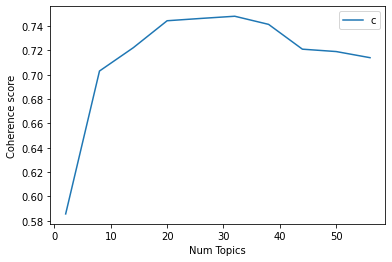

In [37]:
limit=60; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [38]:
for no_of_topics, cv in zip(range(2, 60, 6), coherence_values):
  print("Num Topics:", no_of_topics, " - Coherence Value:", round(cv, 4))

Num Topics: 2  - Coherence Value: 0.5857
Num Topics: 8  - Coherence Value: 0.703
Num Topics: 14  - Coherence Value: 0.7222
Num Topics: 20  - Coherence Value: 0.7443
Num Topics: 26  - Coherence Value: 0.7462
Num Topics: 32  - Coherence Value: 0.748
Num Topics: 38  - Coherence Value: 0.7413
Num Topics: 44  - Coherence Value: 0.721
Num Topics: 50  - Coherence Value: 0.719
Num Topics: 56  - Coherence Value: 0.714


In [40]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=14, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [41]:
print(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0, '0.149*"research" + 0.064*"social" + 0.062*"library" + 0.042*"suicide" + 0.036*"medium" + 0.029*"bioinformatic" + 0.021*"screening" + 0.021*"lesson" + 0.021*"crowdsource" + 0.021*"technology"'), (1, '0.019*"environment" + 0.019*"torch" + 0.002*"learning" + 0.002*"machine" + 0.002*"requirement" + 0.002*"lexicon" + 0.002*"role" + 0.002*"object" + 0.002*"orient" + 0.002*"upper"'), (2, '0.019*"basic" + 0.002*"learning" + 0.002*"machine" + 0.002*"mining" + 0.002*"object" + 0.002*"upper" + 0.002*"lexicon" + 0.002*"role" + 0.002*"discourse" + 0.002*"develop"'), (3, '0.299*"machine" + 0.265*"learning" + 0.046*"technique" + 0.020*"practical" + 0.016*"tool" + 0.016*"task" + 0.013*"radiology" + 0.013*"pattern" + 0.010*"distribute" + 0.009*"impact"'), (4, '0.107*"base" + 0.071*"perspective" + 0.066*"learn" + 0.062*"machine" + 0.056*"medical" + 0.056*"state" + 0.051*"survey" + 0.030*"web" + 0.026*"data" + 0.024*"optimization"'), (5, '0.155*"machine" + 0.121*"learning" + 0.117*"approach" + 0.06

In [42]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
10    -0.236349  0.350404       1        1  44.595758
3      0.280329  0.114597       2        1  13.848994
13     0.162184  0.023929       3        1   7.855620
5      0.207285  0.068422       4        1   7.440429
8     -0.076938 -0.124882       5        1   6.635620
4      0.100536 -0.014550       6        1   6.046191
6     -0.073275 -0.080235       7        1   4.205220
9     -0.059320 -0.081244       8        1   3.615224
0     -0.067974 -0.066760       9        1   2.251150
11    -0.058067 -0.049487      10        1   1.224420
7     -0.052317 -0.046689      11        1   1.024241
1     -0.042570 -0.032122      12        1   0.463274
2     -0.042036 -0.031175      13        1   0.421230
12    -0.041488 -0.030207      14        1   0.372631, topic_info=            Term        Freq       Total Category  logprob  loglift
238     language  202.000000  202.000000  Default   30.000  30.0000
239      natural  189.000000  189.000000  Default   29.000  29.0000
2       learning   86.000000   86.000000  Default   28.000  28.0000
240   processing  186.000000  186.000000  Default   27.000  27.0000
0        machine  124.000000  124.000000  Default   26.000  26.0000
..           ...         ...         ...      ...      ...      ...
24       biology    0.015106    2.665463  Topic14   -6.142   0.4193
25       pattern    0.015106    3.863945  Topic14   -6.142   0.0480
26   recognition    0.015106    2.703474  Topic14   -6.142   0.4051
27       toolkit    0.015106    8.898031  Topic14   -6.142  -0.7862
28        future    0.015106    3.583523  Topic14   -6.142   0.1233

[609 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
100       7  0.814305      advance
133       8  0.508845    advantage
136       2  0.863308  adversarial
11        4  0.146358    algorithm
11        7  0.731792    algorithm
...     ...       ...          ...
208       3  0.862085       vision
268       6  0.762317          web
336       5  0.534806         well
365       1  0.578827      whisper
91        4  0.851554        world

[271 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[11, 4, 14, 6, 9, 5, 7, 10, 1, 12, 8, 2, 3, 13])

Summarization of LDA topics:
1. Usage of NLP to extract the solution for Medical Plaigarism
2. Computer unified assistance for statistical biomedicine architecture
3. Processing medical information using NLP
4. Retrieving information effeciently using customized linguistics
5. Generating current engineering software models using NLP
6. NLP for text mining in health and medicine industry
7. Base for art labeling platform tecnique using NLP
8. NLP for extracting and reviewing application techniques
9. NLP for machine based syntactic feature recognition.
10. NLP toolkit for sentiment and opinion review analysis
11. Extracting information from radiology infant pneumonia
12. Retrieving defects of surveys.
13. Evaluating challenges of clinical records.
14. Ectracting reviews from clinical systems.

## (2) (8 points) Generate K topics by using LSA, the number of topics K should be decided by the coherence score, then summarize what are the topics. You may refer the code here:

https://www.datacamp.com/community/tutorials/discovering-hidden-topics-python

In [43]:
# Write your code here
from gensim.models import LsiModel

In [44]:
lsamodel = LsiModel(corpus, 20, id2word)

In [45]:
def compute_coherence_values_lsi(dictionary, doc_term_matrix, doc_clean, stop, start=2, step=3):
    coherence_values = []
    model_list = []
    for num_topics in range(start, stop, step):
        # generate LSA model
        model = LsiModel(doc_term_matrix, num_topics=20, id2word = dictionary)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=doc_clean, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

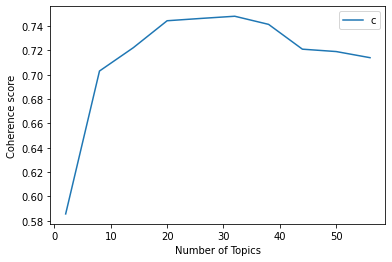

In [46]:
start,stop,step=2,60,6
model_list_lsa, coherence_values_lsa = compute_coherence_values_lsi(id2word, corpus,after_lemmatization,stop, start, step)
x = range(start, stop, step)
plt.plot(x, coherence_values)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [47]:
for no_of_topics, cv in zip(range(2, 60, 6), coherence_values_lsa):
  print("Num Topics:", no_of_topics, " - Coherence Value:", round(cv, 4))

Num Topics: 2  - Coherence Value: 0.5357
Num Topics: 8  - Coherence Value: 0.5282
Num Topics: 14  - Coherence Value: 0.5272
Num Topics: 20  - Coherence Value: 0.5419
Num Topics: 26  - Coherence Value: 0.5376
Num Topics: 32  - Coherence Value: 0.5494
Num Topics: 38  - Coherence Value: 0.5535
Num Topics: 44  - Coherence Value: 0.5342
Num Topics: 50  - Coherence Value: 0.5551
Num Topics: 56  - Coherence Value: 0.545


In [48]:
print(lsamodel.print_topics())

[(0, '0.599*"language" + 0.565*"natural" + 0.549*"processing" + 0.044*"use" + 0.040*"machine" + 0.039*"learning" + 0.037*"learn" + 0.033*"system" + 0.031*"clinical" + 0.027*"base"'), (1, '0.798*"machine" + 0.551*"learning" + 0.173*"learn" + 0.058*"method" + 0.045*"introduction" + 0.044*"application" + -0.041*"language" + -0.040*"natural" + 0.038*"approach" + -0.038*"processing"'), (2, '0.770*"learn" + -0.545*"learning" + 0.207*"machine" + 0.120*"deep" + 0.098*"perspective" + -0.058*"method" + -0.050*"introduction" + -0.049*"technique" + 0.049*"risk" + 0.040*"computer"'), (3, '-0.505*"application" + 0.390*"learning" + 0.361*"learn" + -0.325*"machine" + 0.244*"deep" + 0.223*"base" + 0.216*"approach" + -0.161*"algorithm" + -0.130*"review" + -0.128*"use"'), (4, '0.763*"use" + -0.327*"application" + 0.205*"technique" + 0.161*"sentiment" + 0.131*"medical" + -0.125*"approach" + 0.120*"electronic" + 0.108*"record" + -0.089*"base" + 0.078*"report"'), (5, '-0.476*"process" + 0.442*"processing" +

Summarization of LSA Topics
1. NLP for clinical review system
2. NLP for clinical report detection
3. Electronic based medical recors extraction using NLP
4. Systematic Review of unstructured opinion information using NLP
5. Exraction of medical and suicidal electronic information 
6. NLP for sentimental review
7. NLP for health and systematic reviews
8. Automatic detection and text processing of clinical information
9. Clinical information extraction using deep learning
10. NLP for sentimental representation of survey text
11. Review of information retrieval using NLP
12. Clinical archtecture extraction
13. Summary of detection techniques
14. Software for respiratory detection using deep learning 
15. Machine learning solution for active health survey
16. Technique for research process detection
17. Retrieval process for research care and information mining
18. Home automation control and voice detection using IOT
19. Efficient solution for chinese cluster and whister graphs using NLP
20. Challenges for home automation control using NLP 

## (3) (4 points) Compare the results generated by the two topic modeling algorithms, which one is better? You should explain the reasons in details.

In [ ]:
# Write your answer here (no code needed for this question)

The LSA has lower accuracy when compared to the LDA. Here, the coherence value for optimal number of topics for LSA is 55 where as for LDA is 74. Hence, we get to know that the accuracy of LDA is greater. It means we can easily generalize LDA model to other new documents. LSA has less interpretability among the topics because of dimensionality reduction where as we interpret topic very easily in LDA. I got 32 topics for LDA which are highly interpretable than 50 topics of LSA. LSA has less efficient representation.